In [ ]:
# Setup and Imports
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Get project root (parent of notebooks folder)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.settings.loader import load_scenario
from src.simulation.simulation import run_simulation
from src.simulation.data_loader import SimulationDataLoader
from src.simulation.metrics import compute_all_metrics
from src.plotting.notebook_plotting import (
    create_summary_table,
    create_monthly_metrics_table,
    create_yearly_metrics_table,
    plot_monthly_water_use,
    plot_monthly_self_sufficiency,
    plot_monthly_crop_yields,
    plot_monthly_costs,
    plot_monthly_revenue,
    plot_yearly_comparison
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"Project root: {project_root}")

In [ ]:
# Regenerate all precomputed data (Layer 1)
import subprocess, time

scripts_dir = project_root / "data" / "scripts"

# Tier 1: independent generators (weather, crop params, prices)
tier1 = [
    "generate_weather_data.py",
    "generate_crop_parameters.py",
    "generate_price_data.py",
]

# Tier 2: depend on weather and/or crop params
tier2 = [
    "generate_irrigation_and_yields.py",
    "generate_power_data.py",
    "generate_household_demand.py",
]

def run_scripts(scripts, label):
    print(f"\n{label}")
    for script in scripts:
        t0 = time.time()
        result = subprocess.run(
            [sys.executable, str(scripts_dir / script)],
            capture_output=True, text=True
        )
        elapsed = time.time() - t0
        status = "ok" if result.returncode == 0 else "FAILED"
        print(f"  {script}: {status} ({elapsed:.1f}s)")
        if result.returncode != 0:
            print(f"    {result.stderr.strip()}")

t_start = time.time()
run_scripts(tier1, "Tier 1: Independent generators")
run_scripts(tier2, "Tier 2: Dependent generators (need weather + crop params)")
print(f"\nAll data regenerated in {time.time() - t_start:.1f}s")

In [2]:
# Path to scenario file (relative to project root)
scenario_path = project_root / "settings" / "mvp-settings.yaml"

print(f"Loading scenario from: {scenario_path}")
print(f"File exists: {scenario_path.exists()}")

# Load scenario
print("Loading scenario...")
scenario = load_scenario(str(scenario_path))

print(f"\nScenario: {scenario.metadata.name}")
print(f"Description: {scenario.metadata.description}")
print(f"Period: {scenario.metadata.start_date} to {scenario.metadata.end_date}")
print(f"Farms: {len(scenario.farms)}")
for farm in scenario.farms:
    print(f"  - {farm.name} ({farm.area_ha} ha, policy: {farm.water_policy.name})")

Loading scenario from: /Users/dpbirge/GITHUB/community-agri-pv/settings/mvp-settings.yaml
File exists: True
Loading scenario...

Scenario: single_farm_dev
Description: Single farm scenario for detailed water, crop, and economic analysis
Period: 2015-01-01 to 2020-12-31
Farms: 1
  - Demo Farm (125 ha, policy: cheapest_source)


In [3]:
# Run simulation
print("Running simulation...")
data_loader = SimulationDataLoader(
    registry_path=str(project_root / "settings" / "data_registry.yaml"),
    project_root=str(project_root),
    use_research_prices=False  # Use toy prices for toy scenario
)
simulation_state = run_simulation(scenario, data_loader, verbose=True)

print("\n✓ Simulation complete!")

Running simulation...
Starting simulation: 2015-01-01 to 2020-12-31
Farms: 1, Treatment energy: 2.20 kWh/m3
System constraints per farm: GW max 500 m3/day, Treatment max 2000 m3/day
  Simulated 365 days...
Year boundary: 2015 -> 2016
  Simulated 730 days...
Year boundary: 2016 -> 2017
  Simulated 1095 days...
Year boundary: 2017 -> 2018
  Simulated 1460 days...
Year boundary: 2018 -> 2019
  Simulated 1825 days...
Year boundary: 2019 -> 2020
  Simulated 2190 days...
Simulation complete: 2192 days, 6 yearly metrics

✓ Simulation complete!


In [4]:
# Compute metrics
print("Computing metrics...")
all_metrics = compute_all_metrics(simulation_state)

print(f"\nMetrics computed:")
print(f"  - {len(all_metrics['farm_metrics'])} farm yearly records")
print(f"  - {len(all_metrics['monthly_metrics'])} monthly records")
print(f"  - {len(all_metrics['community_metrics'])} community yearly records")

Computing metrics...

Metrics computed:
  - 6 farm yearly records
  - 60 monthly records
  - 6 community yearly records


In [5]:
# Display data tables
print("Summary:")
summary_df = create_summary_table(simulation_state)
display(summary_df)

print("\nYearly Metrics:")
yearly_df = create_yearly_metrics_table(all_metrics)
display(yearly_df)

Summary:


,Farm,Policy,Total Water (m³),Total Cost (USD),Crop Yield (kg),Crop Revenue (USD),Self-Sufficiency (%)
0,Demo Farm,cheapest_source,"625,122","$451,290.76","5,175,313","$4,245,605.12",23.0%



Yearly Metrics:


,Year,Farm,Policy,Water (m³),Cost (USD),Yield (kg),Revenue (USD),Self-Suff (%)
0,2015,Demo Farm,cheapest_source,610799.753125,382405.579036,4.210337e+06,3.933985e+06,21.967945
1,2016,Demo Farm,cheapest_source,662278.825000,428341.692312,5.070516e+06,3.443104e+06,21.743108
2,2017,Demo Farm,cheapest_source,667898.312500,446191.194201,4.829512e+06,3.733843e+06,21.554268
3,2018,Demo Farm,cheapest_source,635394.643750,433072.558673,5.092258e+06,3.884764e+06,22.656163
4,2019,Demo Farm,cheapest_source,648768.615625,457580.022923,5.041908e+06,3.624056e+06,22.195895
5,2020,Demo Farm,cheapest_source,625122.096875,451290.755504,5.175313e+06,4.245605e+06,23.023599


In [6]:
# Crop Tracking Diagnostic
print("Crop Tracking Diagnostic:")
print("="*70)
farm = simulation_state.farms[0]
print(f"Total crops tracked: {len(farm.crops)}")
print(f"Harvested crops: {sum(1 for c in farm.crops if c.is_harvested)}")

print(f"\nCrops by planting year:")
from collections import Counter
planting_years = Counter(c.planting_date.year for c in farm.crops)
for year in sorted(planting_years.keys()):
    harvested = sum(1 for c in farm.crops if c.planting_date.year == year and c.is_harvested)
    print(f"  {year}: {planting_years[year]} planted, {harvested} harvested")

print(f"\nSample crops from each year (first 2):")
for year in sorted(planting_years.keys()):
    year_crops = [c for c in farm.crops if c.planting_date.year == year][:2]
    for crop in year_crops:
        print(f"  {crop.crop_name} - Plant: {crop.planting_date}, Harvest: {crop.harvest_date}, "
              f"Harvested: {crop.is_harvested}, Revenue: ${crop.harvest_revenue_usd:,.0f}")

Crop Tracking Diagnostic:
Total crops tracked: 30
Harvested crops: 29

Crops by planting year:
  2015: 5 planted, 5 harvested
  2016: 5 planted, 5 harvested
  2017: 5 planted, 5 harvested
  2018: 5 planted, 5 harvested
  2019: 5 planted, 5 harvested
  2020: 5 planted, 4 harvested

Sample crops from each year (first 2):
  tomato - Plant: 2015-02-15, Harvest: 2015-06-30, Harvested: True, Revenue: $2,330,378
  potato - Plant: 2015-01-15, Harvest: 2015-05-15, Harvested: True, Revenue: $504,891
  tomato - Plant: 2016-02-15, Harvest: 2016-06-29, Harvested: True, Revenue: $1,332,806
  potato - Plant: 2016-01-15, Harvest: 2016-05-14, Harvested: True, Revenue: $465,409
  tomato - Plant: 2017-02-15, Harvest: 2017-06-30, Harvested: True, Revenue: $1,598,727
  potato - Plant: 2017-01-15, Harvest: 2017-05-15, Harvested: True, Revenue: $448,465
  tomato - Plant: 2018-02-15, Harvest: 2018-06-30, Harvested: True, Revenue: $1,710,936
  potato - Plant: 2018-01-15, Harvest: 2018-05-15, Harvested: True, R

In [7]:
# Check yield and revenue data distribution by year
print("Revenue Analysis:")
print("="*60)

# From yearly metrics
yearly_df = create_yearly_metrics_table(all_metrics)
print("\nYearly Revenue from Farm Metrics:")
print(yearly_df[['Year', 'Revenue (USD)']].to_string(index=False))

# Expected vs Actual
expected_revenues = {
    2015: 4495405,
    2016: 3372636,
    2017: 3731049,
    2018: 3836596,
    2019: 3768426,
    2020: 4168648
}

print("\n\nExpected vs Actual Revenue Comparison:")
print(f"{'Year':<6} {'Expected':<15} {'Actual':<15} {'Difference':<15} {'% Diff'}")
print("-" * 70)
for _, row in yearly_df.iterrows():
    year = row['Year']
    actual = row['Revenue (USD)']
    expected = expected_revenues.get(year, 0)
    diff = actual - expected
    pct_diff = (diff / expected * 100) if expected > 0 else 0
    print(f"{year:<6} ${expected:>12,.0f}  ${actual:>12,.0f}  ${diff:>12,.0f}  {pct_diff:>6.1f}%")

print("\n\nMonthly Revenue Summary:")
monthly_df = create_monthly_metrics_table(all_metrics)
monthly_sum = monthly_df.groupby('Year')['Revenue (USD)'].sum()
print(monthly_sum)

Revenue Analysis:

Yearly Revenue from Farm Metrics:
 Year  Revenue (USD)
 2015   3.933985e+06
 2016   3.443104e+06
 2017   3.733843e+06
 2018   3.884764e+06
 2019   3.624056e+06
 2020   4.245605e+06


Expected vs Actual Revenue Comparison:
Year   Expected        Actual          Difference      % Diff
----------------------------------------------------------------------
2015   $   4,495,405  $   3,933,985  $    -561,420   -12.5%
2016   $   3,372,636  $   3,443,104  $      70,468     2.1%
2017   $   3,731,049  $   3,733,843  $       2,794     0.1%
2018   $   3,836,596  $   3,884,764  $      48,168     1.3%
2019   $   3,768,426  $   3,624,056  $    -144,370    -3.8%
2020   $   4,168,648  $   4,245,605  $      76,957     1.8%


Monthly Revenue Summary:
Year
2015    3.933985e+06
2016    3.443104e+06
2017    3.733843e+06
2018    3.884764e+06
2019    3.624056e+06
2020    4.245605e+06
Name: Revenue (USD), dtype: float64


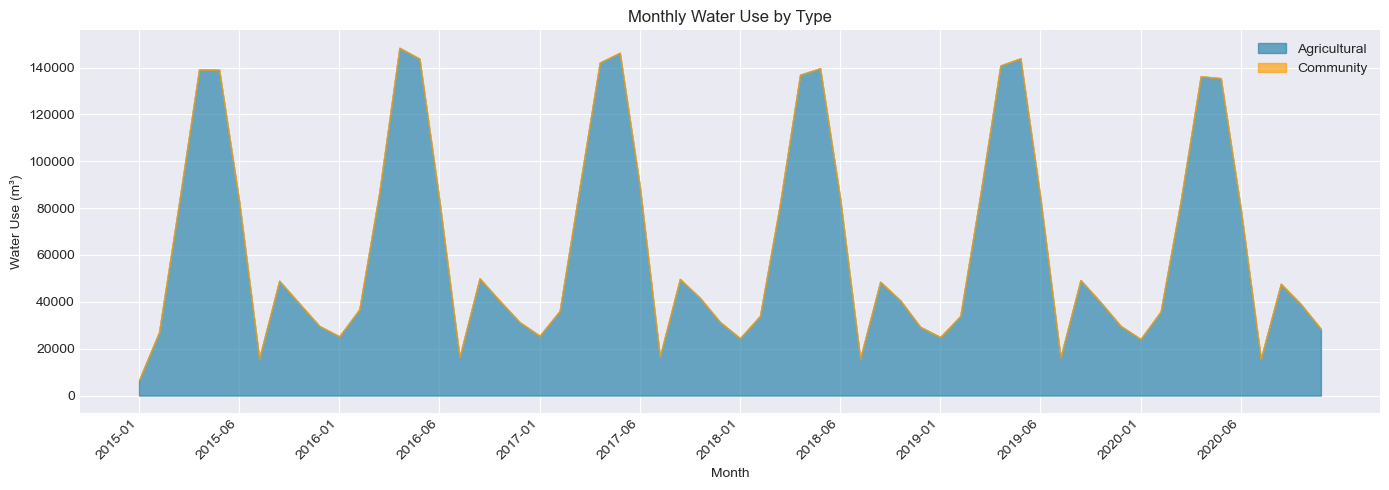

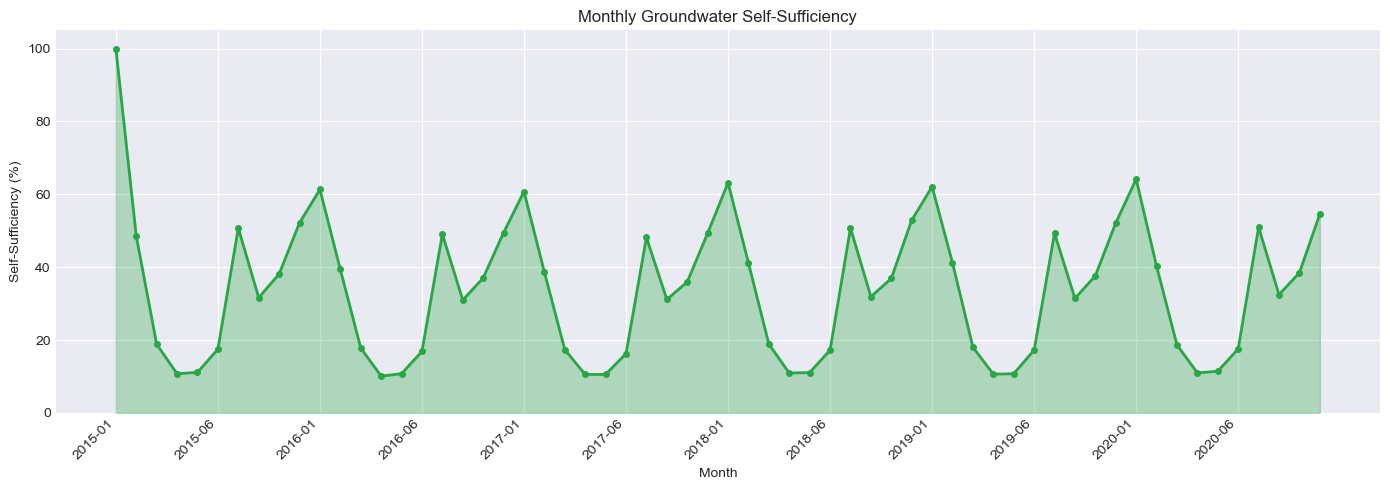

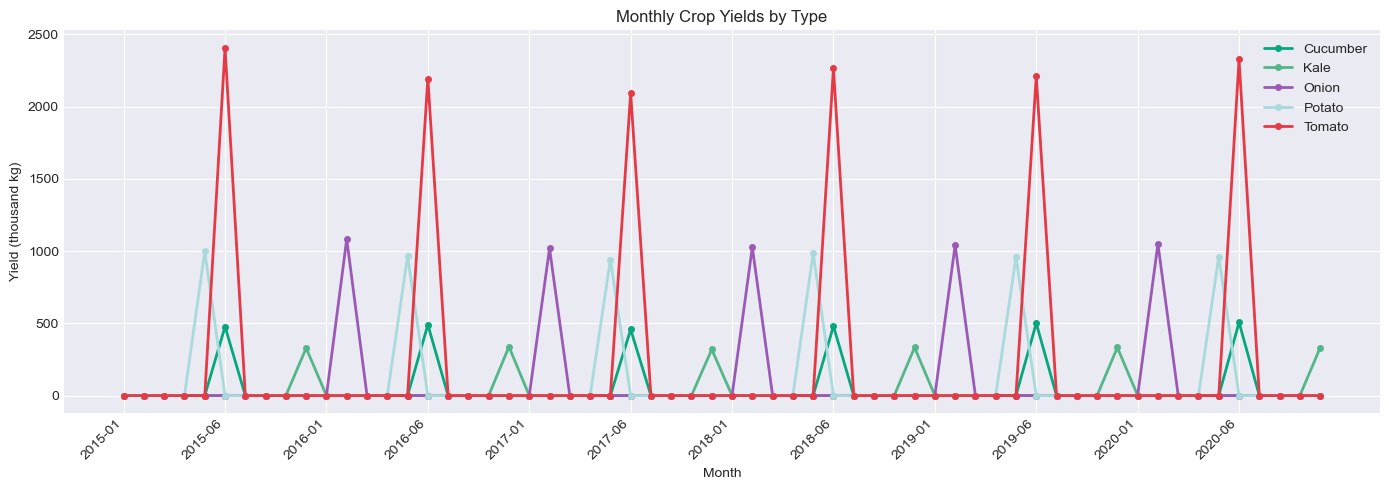

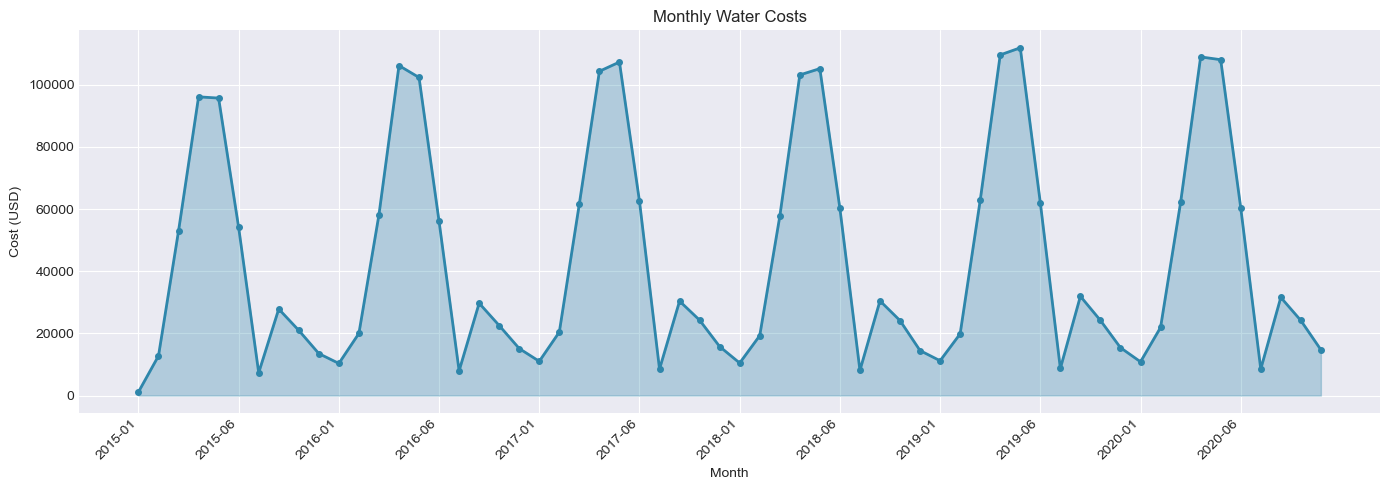

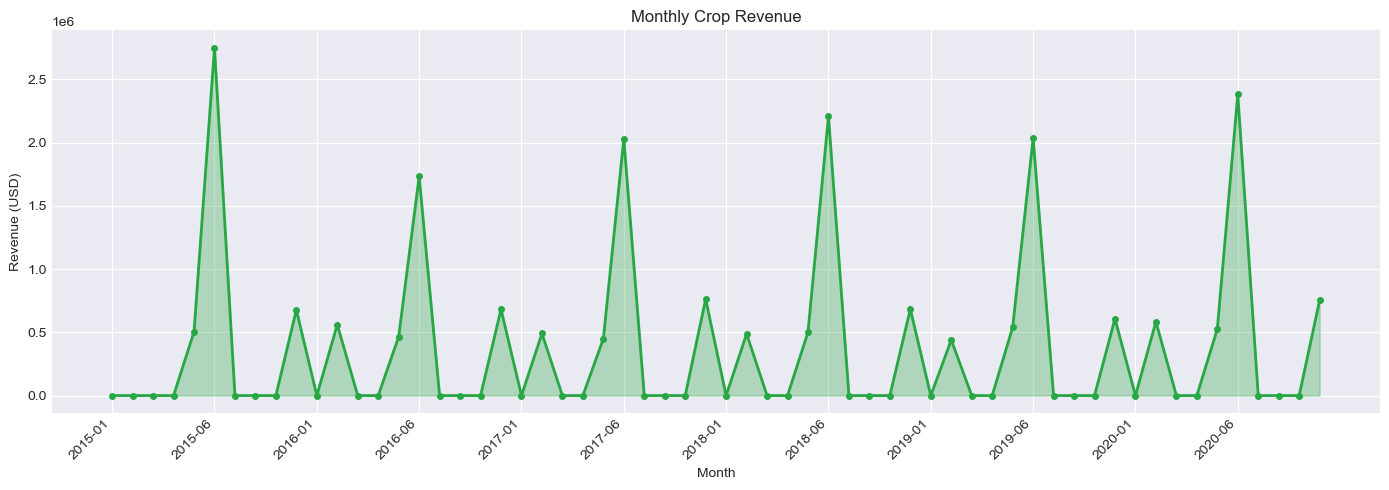

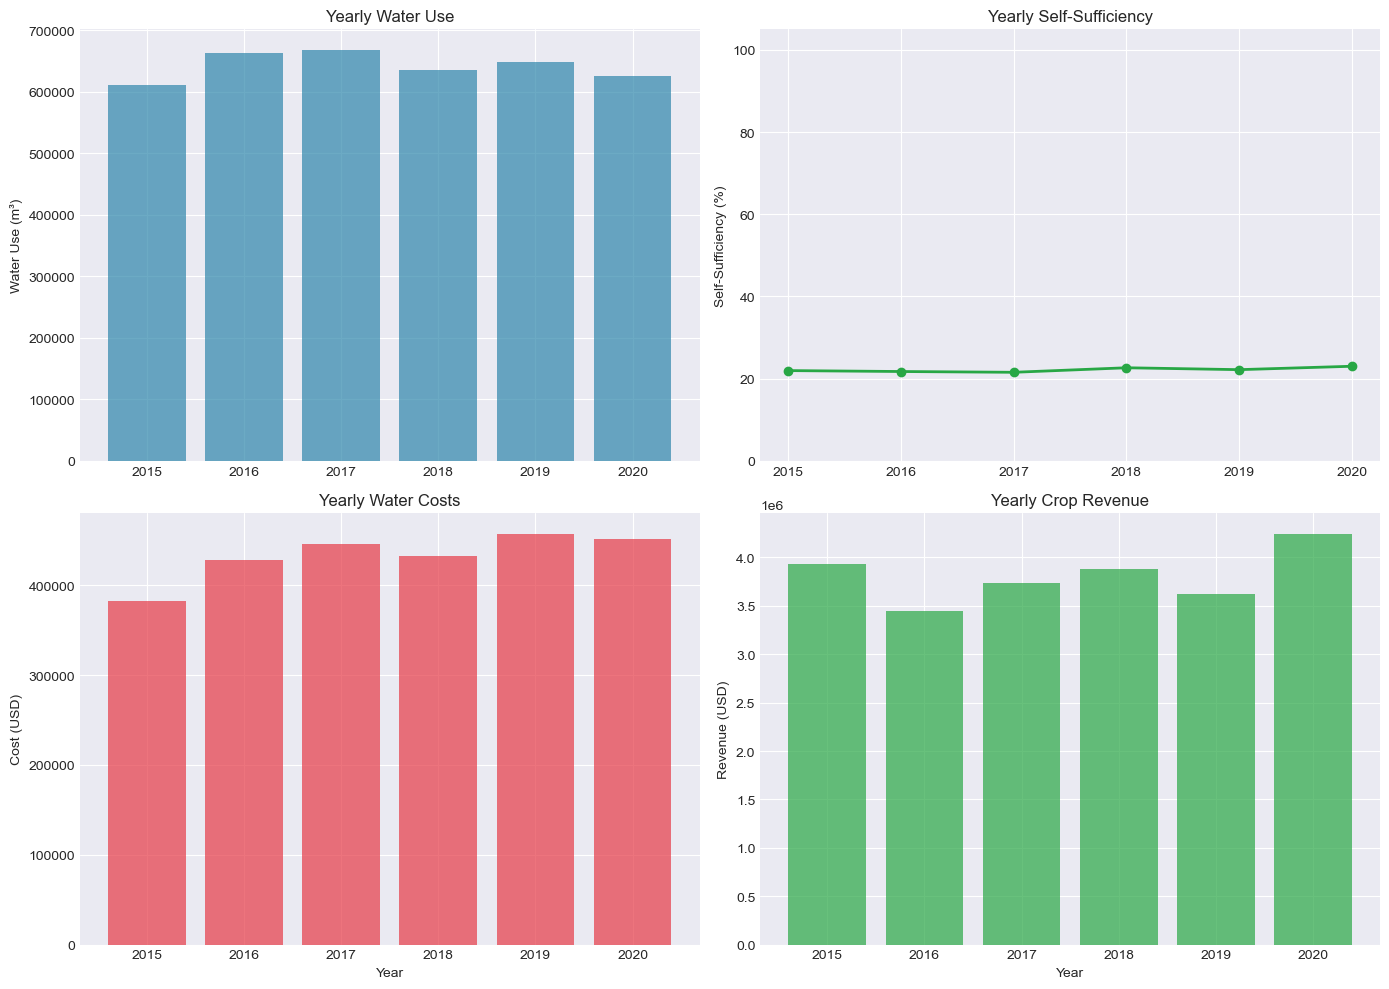

In [8]:
# Generate all plots
plot_monthly_water_use(all_metrics)
plot_monthly_self_sufficiency(all_metrics)
plot_monthly_crop_yields(all_metrics)
plot_monthly_costs(all_metrics)
plot_monthly_revenue(all_metrics)
plot_yearly_comparison(all_metrics)